This notebook simulates graph data with $N=30$ and infers the graph using DAT-Graph. It requires a GPU to run.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader

from dat_graph.plotting import compare_mats
from dat_graph.datasets import SimulationDataset
from dat_graph.moral_test import MoralTester


In [2]:
# synthetic data parameters

n_nodes = 30
s = 2
frac_intervention = 0.25 # fraction of variables that are intervened upon

n_observation = 10000 # number observational data
n_intervention = 500 # observations per intervened variable

In [3]:
# DAT-Graph hyperparameters

thresh_moral = 8e-3
thresh_skel = 1e-4
thresh_v_struct = 0.2
thresh_int_ad = 1e-3

train_batch_size = 256

config_args_moral = {
    'hidden_width': 200,
    'n_layers': 3,
    'stats': lambda x: torch.concat([x[..., None],
                                    ((x)**2)[..., None],], axis=-1),
}

train_args_moral = {
    'n_steps': 30000,
    'sparsity': 1e-2,
    'lr': 1e-4,
}

config_args_dat = {
    'hidden_width': 200,
    'n_layers': 3,
    'stats': lambda x: torch.concat([x[..., None],
                                    ((x)**2)[..., None],], axis=-1),
}

train_args_dat = {
    'n_steps': 10000,
    'lr': 3e-4,
}

# Simulate data

In [4]:
device = 'cuda'
print('device:', device)
dtype = torch.float32

device: cuda


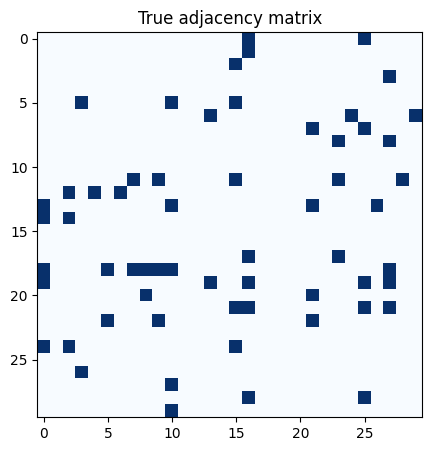

In [5]:
from sdcd.simulated_data.examples import random_model_gaussian_global_variance

# build the causal model using code from SDCD
n_edge = s * n_nodes   
causal_model = random_model_gaussian_global_variance(n_nodes, n_edge, hard=True)
ad_mat = np.array([np.isin(np.arange(n_nodes), causal_model.get_parents(i)) for i in range(n_nodes)])

plt.figure(figsize=[5, 5])
plt.title("True adjacency matrix")
plt.imshow(ad_mat, cmap='Blues')

# simulate data
df = causal_model.generate_dataframe_from_all_distributions(n_observation, n_intervention)
observation_data = df.iloc[:n_observation, :n_nodes].to_numpy()
intervention_data = df.iloc[n_observation:, :n_nodes].to_numpy().reshape([n_nodes, n_intervention, n_nodes])

# randomly select which variables are intervened upon
intervention_inds = (np.random.choice(np.arange(n_nodes), int(n_nodes * frac_intervention), replace=False).sort()
                     or [])
intervention_data = intervention_data[intervention_inds]
train_data = np.concatenate([observation_data, intervention_data.reshape((-1, n_nodes))])
# make an indicator variable which is 1 if a variable is intervened upon
train_intervene = np.concatenate([np.zeros([n_observation, n_nodes]),
                                  np.tile(np.eye(n_nodes)[intervention_inds][:, None, :],
                                          (1, n_intervention, 1)).reshape((-1, n_nodes))])
# for each observation, write which variable is intervened upon
train_regimens = np.concatenate([np.zeros(n_observation),
                                 1 + np.tile(np.arange(n_nodes)[intervention_inds][:, None],
                                             (1, n_intervention)).reshape((-1))])
# shuffle data
shuffle = np.arange(len(train_data))
np.random.shuffle(shuffle)
train_data = train_data[shuffle]
train_intervene = train_intervene[shuffle]
train_regimens = train_regimens[shuffle]

# normalize all data
mus = train_data.mean(axis=0)
train_data = train_data - mus

stds =  train_data.std(axis=0)
train_data /= stds

In [6]:
# set up dataloader
train_dataloader = SimulationDataset(torch.Tensor(train_data).to(dtype),
                                     torch.Tensor(train_intervene).to(torch.bool),
                                     torch.Tensor(train_regimens).to(dtype))

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_dataloader = iter(cycle(DataLoader(train_dataloader, batch_size=train_batch_size,
                                         shuffle=True, num_workers=8,
                                         pin_memory=True, drop_last=True)))

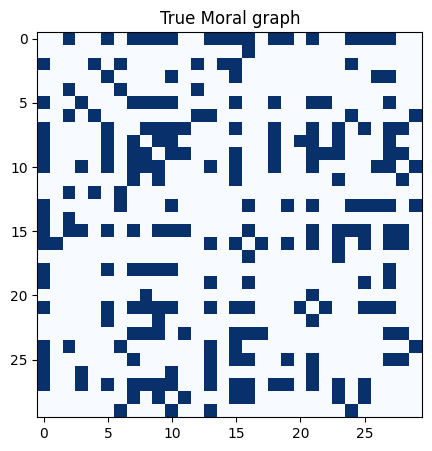

In [7]:
# calculate the true moral graph
moral = np.eye(n_nodes) + ad_mat
moral = moral.T @ moral
moral = ((moral>0) - np.eye(n_nodes)).astype(int)

plt.figure(figsize=[5, 5])
plt.title("True Moral graph")
plt.imshow(moral, cmap='Blues')

# Step 1: Learn the moral graph.

Mean error: 7.5: 100%|████████████████████| 30000/30000 [05:18<00:00, 94.28it/s]


Text(0.5, 1.0, 'Full importance map')

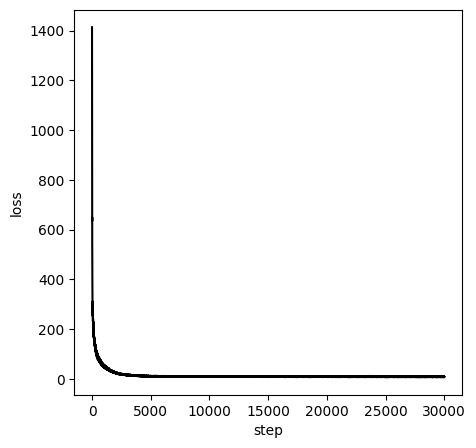

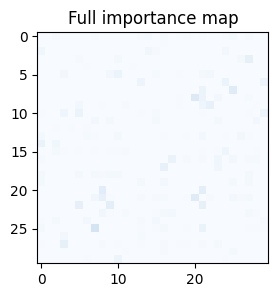

In [8]:
moral_tester = MoralTester(n_nodes, device, dtype,
                           intervention_inds=intervention_inds,
                           **config_args_moral)
moral_tester.train(train_dataloader, **train_args_moral)

# Plot importance of variables
variable_importances = moral_tester.get_importance().detach().cpu().numpy()
plt.figure(figsize=[3, 3])
plt.imshow(variable_importances,
           cmap='Blues', vmin=0, vmax=1)
plt.title("Full importance map")

n misoriented edges: 0.0
n missing edges: 64.0
n extra edges: 0.0
SHD is: 32.0
Precision is: 1.0
Recall is: 0.7264957264957265
F1 is: 0.8415841584158416


/scratch/aa11803/DAT-graph/dat_graph/plotting.py:40: RuntimeWarning: invalid value encountered in scalar divide
  precision = (mask * tp).sum() / (mask * tested).sum()


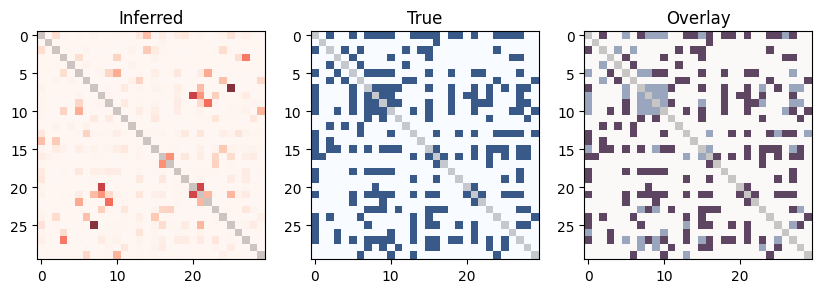

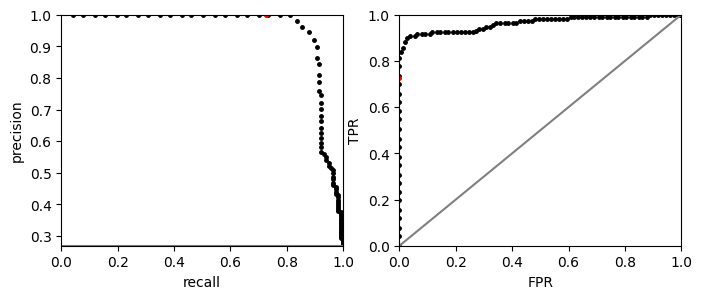

In [9]:
# Plot the precision recall and ROC curves of predicting the moral graph using
# variable importance. Red dot is our threshold.
moral_inferred = (variable_importances + variable_importances.T)[:n_nodes, :n_nodes]
mask = 1-np.eye(n_nodes)
_ = compare_mats(moral, moral_inferred, mask, thresh_moral, skeleton=True)

In [10]:
# If there are interventions, Plot the precision recall and ROC curves
# of predicting parents of intervened variables using variable importance.
# Red dot is our threshold.
if len(intervention_inds)>0:
    ad_mat_inferred = np.zeros([n_nodes, n_nodes])
    sub_mat = variable_importances[:n_nodes, n_nodes:]
    ad_mat_inferred[:, intervention_inds] = sub_mat
    np.fill_diagonal(ad_mat_inferred, 0)
    ad_mat_inferred = ad_mat_inferred.T
    
    mask = np.tile(np.isin(np.arange(n_nodes), intervention_inds)[:, None],
                   (1, n_nodes))
    
    compare_mats(ad_mat, ad_mat_inferred, mask, thresh_int_ad)

# Step 2: Learn the skeleton.

Text(0.5, 1.0, 'Inferred moral graph')

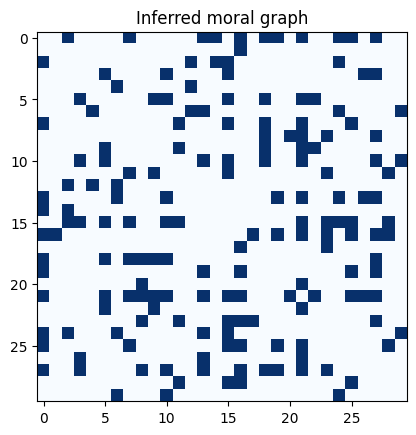

In [11]:
# build a moral graph over all observation and intervention variables
moral_inferred = variable_importances
# remove edges going into intervention variables
moral_inferred[n_nodes:] = 0
# threshold
moral_inferred = (moral_inferred + moral_inferred.T)
moral_inferred = (moral_inferred > thresh_moral).astype(int)
if len(intervention_inds)>0:
    # Threshold matrix of parents of intervened variables
    ad_mat_inferred = (ad_mat_inferred > thresh_int_ad).astype(int)
    # Orient these edges in the moral graph
    moral_inferred[:n_nodes, :n_nodes] = ((moral_inferred[:n_nodes, :n_nodes]
                                        + ad_mat_inferred - ad_mat_inferred.T) > 0).astype(int)
    # remove edges going into intervention variables
    moral_inferred[n_nodes:] = 0
    
plt.imshow(moral_inferred, cmap='Blues', vmin=0, vmax=1)
plt.title("Inferred moral graph")

Var. expl.: 244.47000122070312Pred. error: 467.3599853515625: 100%|█| 10000/1000


step: 0
step: 1000
step: 2000
step: 3000
step: 4000


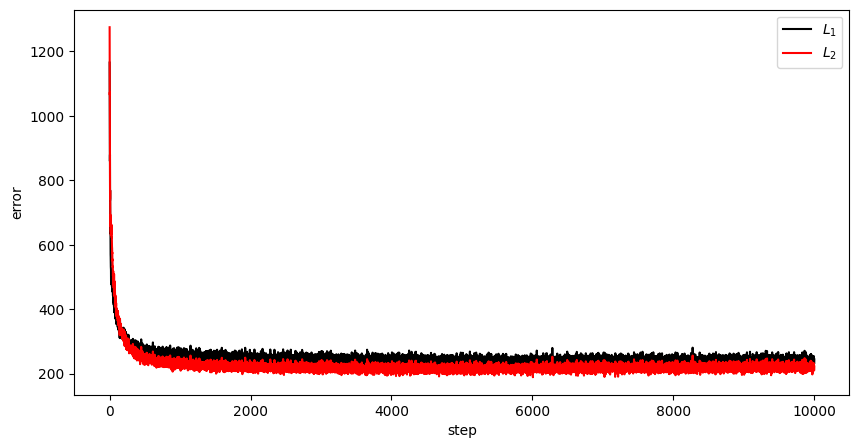

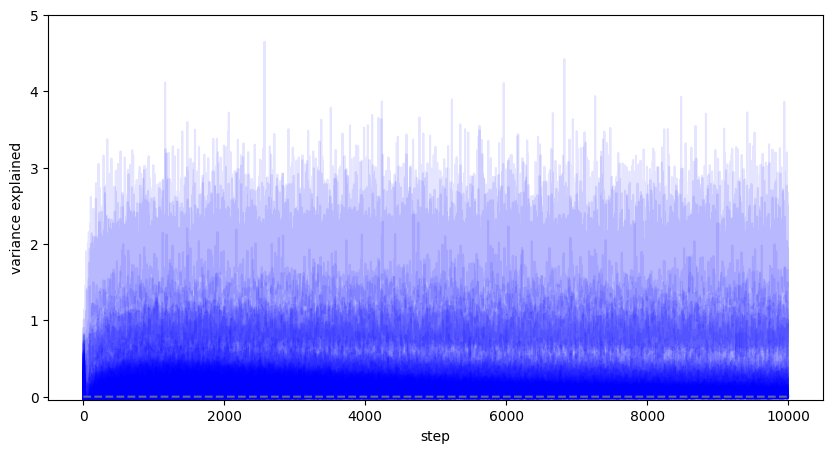

In [12]:
from dat_graph.dat_test import DATTester   

dat_tester = DATTester(moral_inferred, device, dtype, **config_args_dat)
# get edges that were tessted and their Markov blankets
test_edges, moral_map = dat_tester.get_test_edges_mbs()

# train regressors and psis
_ = dat_tester.train(train_dataloader, **train_args_dat)

# get variance explained and psis for each tested edge
var_explained = dat_tester.test(train_dataloader, n_steps=5000)
psis = dat_tester.get_psis()

In [13]:
# make skeleton

uncertain_edges = (moral_inferred * moral_inferred.T).astype(float)
# initialize skeleton with edges we learned with interventions
skeleton_inferred = (moral_inferred - uncertain_edges)[:n_nodes, :n_nodes]
# add variance explained to each tested edge
for (i, j), accept, in zip(test_edges, var_explained):
    skeleton_inferred[i, j] += accept ** 2
    skeleton_inferred[j, i] += accept ** 2

n misoriented edges: 0.0
n missing edges: 8.0
n extra edges: 14.0
SHD is: 11.0
Precision is: 0.8888888888888888
Recall is: 0.9333333333333333
F1 is: 0.910569105691057


/scratch/aa11803/DAT-graph/dat_graph/plotting.py:40: RuntimeWarning: invalid value encountered in scalar divide
  precision = (mask * tp).sum() / (mask * tested).sum()


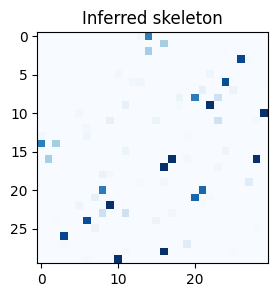

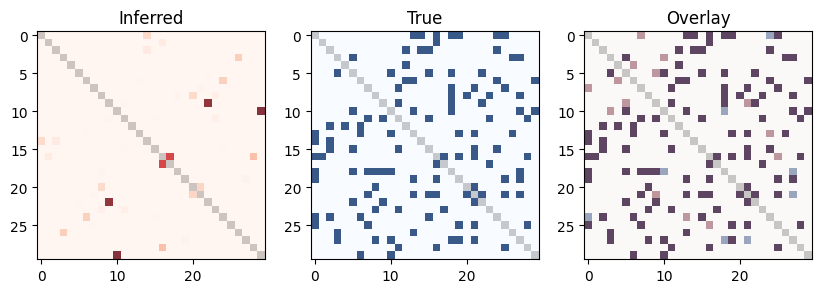

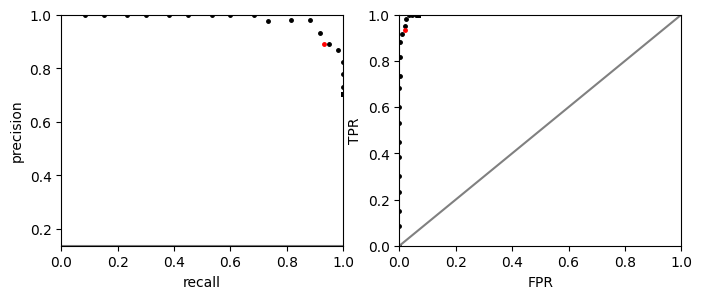

In [14]:
# Plot the precision recall and ROC curves of predicting the skeleton using
# variance explained. Red dot is our threshold.
# Note this plot double counts mistakes, so true SHD is half of what is shown!

true_skeleton = (ad_mat != 0) + (ad_mat.T != 0)
# skeleton may have some directed edges we learned from interventions
symmetric_skeleton_inferred = (skeleton_inferred + skeleton_inferred.T) / 2
mask = 1-np.eye(n_nodes)

plt.figure(figsize=[3, 3])
plt.imshow(skeleton_inferred,
           cmap='Blues', vmin=0, vmax=1)
plt.title("Inferred skeleton")

_ = compare_mats(true_skeleton, symmetric_skeleton_inferred, mask, thresh_skel, skeleton=True)

# Step 3: orient v-structures using $\psi$s

In [15]:
from dat_graph.graph_ops import orient_v_structures, meeks_rules, remove_edges_to_dag


Text(0.5, 1.0, 'Inferred adjacency matrix')

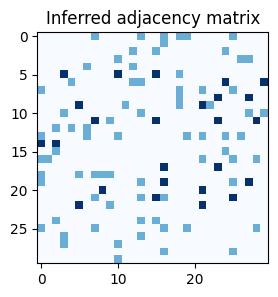

In [16]:
ad_mat_inferred = (skeleton_inferred > thresh_skel).astype(float)
# set the value of unoriented edges to 0.5
ad_mat_inferred[ad_mat_inferred*ad_mat_inferred.T > 0] = 0.5

ad_mat_inferred = orient_v_structures(ad_mat_inferred, psis,
                                      symmetric_skeleton_inferred>thresh_skel,
                                      test_edges, moral_map, thresh_v_struct)

plt.figure(figsize=[3, 3])
plt.imshow(ad_mat_inferred,
           cmap='Blues', vmin=0, vmax=1)
plt.title("Inferred adjacency matrix")

Text(0.5, 1.0, "Inferred adjacency matrix after Meek's rules")

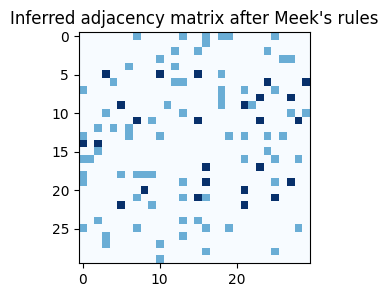

In [17]:
# apply Meek's rules
ad_mat_guess = meeks_rules(ad_mat_inferred)

plt.figure(figsize=[3, 3])
plt.imshow(ad_mat_inferred,
           cmap='Blues', vmin=0, vmax=1)
plt.title("Inferred adjacency matrix after Meek's rules")

Text(0.5, 1.0, 'Fully oriented inferred adjacency matrix')

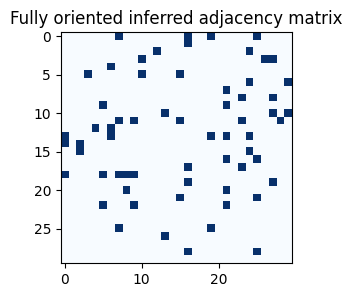

In [18]:
# randomly orient unoriented edges and reapply Meek's rules
while (ad_mat_inferred == 0.5).sum() != 0:
    unoriented_edges = np.argwhere(ad_mat_inferred == 0.5)
    i, j = unoriented_edges[np.random.choice(len(unoriented_edges))]
    if np.random.uniform() > 0.5:
        ad_mat_inferred[i, j] = 1
        ad_mat_inferred[j, i] = 0
    else:
        ad_mat_inferred[i, j] = 0
        ad_mat_inferred[j, i] = 1
    ad_mat_inferred = meeks_rules(ad_mat_inferred)
plt.figure(figsize=[3, 3])
plt.imshow(ad_mat_inferred,
           cmap='Blues', vmin=0, vmax=1)
plt.title("Fully oriented inferred adjacency matrix")



Edges removed: 1
Edges removed: 2


Text(0.5, 1.0, 'Inferred adjacency matrix DAG')

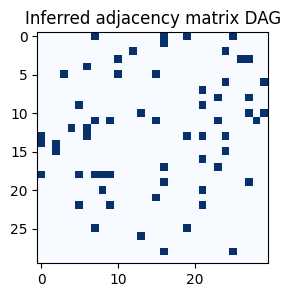

In [19]:
# remove edges until we get a DAG
ad_mat_inferred = remove_edges_to_dag(ad_mat_inferred)
plt.figure(figsize=[3, 3])
plt.imshow(ad_mat_inferred,
           cmap='Blues', vmin=0, vmax=1)
plt.title("Inferred adjacency matrix DAG")

n misoriented edges: 15.0
n missing edges: 5.0
n extra edges: 6.0
SHD is: 26.0
Precision is: 0.6557377049180327
Recall is: 0.6666666666666666
F1 is: 0.6611570247933883


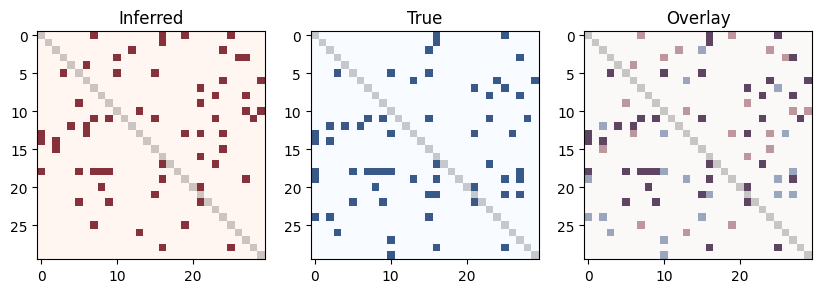

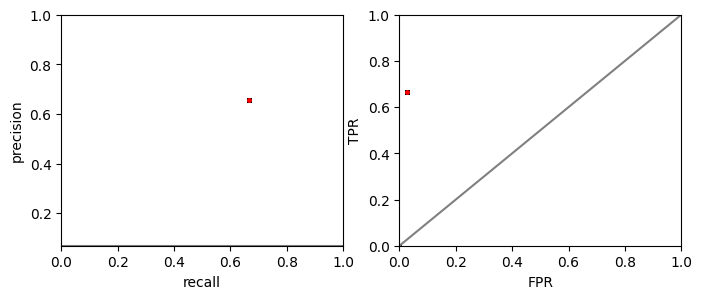

In [20]:
mask = 1-np.eye(n_nodes)

_ = compare_mats(ad_mat, ad_mat_inferred, mask, 0.9)